In [3]:
# pip install torch torchvision transformers faiss-cpu matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 52.5 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import json
import torch
import faiss
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BlipProcessor, BlipForConditionalGeneration

#### Load dataset

In [5]:
dataset_path = "/kaggle/input/applied-data-mining-final-project-t-shirt-data/tshirt" 
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('jpg', 'png', 'jpeg'))]

# Task 1:

#### Load pretrained model

In [6]:
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).eval()
processor = CLIPProcessor.from_pretrained(model_name)

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

#### Preprocess

In [7]:
def preprocess(img_path):
    image = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.481, 0.457, 0.408], std=[0.268, 0.261, 0.275]) 
    ])
    image = transform(image).unsqueeze(0) 
    return {"pixel_values": image}

If we use a different set of mean and standard deviation values for CLIP preprocessing, it can significantly impact model performance.
If we use different values, the model won't recognize features in the same way it was trained to, embeddings from different input images won't align in the feature space.\
If the input distribution shifts (due to wrong normalization), the model sees data differently than it did during training and shifts the numerical range, distorting cosine similarity calculations.

#### Embedding

In [8]:
img_embeddings = []
img_paths = []
with torch.no_grad():
    for img_file in image_files:
        img_path = os.path.join(dataset_path, img_file)
        inputs = preprocess(img_path)
        embedding = model.get_image_features(**inputs)
        img_embeddings.append(embedding.cpu().numpy())
        img_paths.append(img_path)

img_embeddings = np.vstack(img_embeddings)
index = faiss.IndexFlatL2(img_embeddings.shape[1]) 
index.add(img_embeddings)

In [9]:
def retrieve_images(text_query, top_k=10):
    with torch.no_grad():
        inputs = processor(text=[text_query], return_tensors="pt")
        text_embedding = model.get_text_features(**inputs).cpu().numpy()
        
    distances, indices = index.search(text_embedding, top_k)
    
    fig, axes = plt.subplots(1, top_k, figsize=(15, 5))
    for i, idx in enumerate(indices[0]):
        img = Image.open(img_paths[idx]) 
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.show()

### Query

In [10]:
print("Enter query as input :")
query = input()

Enter query as input :


 Green t-shirt


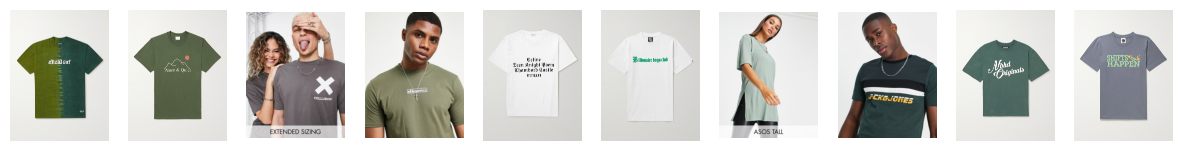

In [11]:
retrieve_images(query, top_k=10) 

# Task 2

#### Load pretrained model

In [12]:
model_name = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name).eval()

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [13]:
def generate_caption(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        output = model.generate(**inputs)
    caption = processor.decode(output[0], skip_special_tokens=True)
    return caption

In [14]:
print("Enter an image path as input :")
input_img = input()

Enter an image path as input :


 /kaggle/input/applied-data-mining-final-project-t-shirt-data/tshirt/1015.jpg


In [15]:
image = Image.open(input_img).convert("RGB")

inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    output = model.generate(**inputs)

caption = processor.decode(output[0], skip_special_tokens=True)
print(f"Generated Caption: {caption}")

Generated Caption: a p striped cotton t - shirt


# Task 3

In [ ]:
processor_clip = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

processor_blip = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [ ]:
def generate_caption(image_path):

    raw_image = Image.open(image_path).convert("RGB")

    inputs = processor_blip(raw_image, return_tensors="pt")

    out = model_blip.generate(**inputs)

    caption = processor_blip.decode(out[0], skip_special_tokens=True)
    return caption

In [ ]:
def generate_captions_for_images(image_paths):

    captions = []
    for image_path in image_paths:
        caption = generate_caption(image_path)
        captions.append(caption)
    return captions

In [ ]:
def display_images_with_captions(image_paths, captions, top_k=5):

    fig, axes = plt.subplots(1, top_k, figsize=(15, 5))

    for i in range(top_k):
        img = Image.open(image_paths[i])
        axes[i].imshow(img)
        axes[i].axis('off')

        axes[i].set_xlabel(captions[i], fontsize=10, wrap=True)

    plt.tight_layout()
    plt.show()

In [ ]:
def retrieve_images_by_text(query, image_paths, captions, top_k=5):

    inputs = processor_clip(text=query, return_tensors="pt", padding=True)
    query_embeddings = clip_model.get_text_features(**inputs)
    query_embeddings = query_embeddings.squeeze(0).detach().numpy()

    caption_embeddings = []
    for caption in captions:
        inputs = processor_clip(text=caption, return_tensors="pt", padding=True)
        caption_embedding = clip_model.get_text_features(**inputs)
        caption_embeddings.append(caption_embedding.squeeze(0).detach().numpy())


    query_embeddings = query_embeddings.reshape(1, -1)
    caption_embeddings = np.array(caption_embeddings)

    similarities = cosine_similarity(query_embeddings, caption_embeddings)

    ranked_indices = np.argsort(similarities[0])[::-1]
    top_image_paths = [image_paths[i] for i in ranked_indices[:top_k]]
    top_captions = [captions[i] for i in ranked_indices[:top_k]]

    return top_image_paths, top_captions

In [16]:
def display_retrieved_images(query, image_paths, captions, top_k=5):

    top_image_paths, top_captions = retrieve_images_by_text(query, image_paths, captions, top_k)

    fig, axes = plt.subplots(1, top_k, figsize=(15, 5))
    for i in range(top_k):
        img = Image.open(top_image_paths[i])
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_xlabel(top_captions[i], fontsize=10, wrap=True)

    plt.tight_layout()
    plt.show()

In [ ]:
captions = generate_captions_for_images(img_paths)

query = "black T-shirt"

display_retrieved_images(query, image_paths, captions, top_k=5)

# **Report**

In this project, I developed an **image retrieval** and **image captioning** system using **pretrained models**. My goal was to process a dataset of **T-shirt images** and create a system that allows users to search for relevant images based on text queries. Next, I implemented an image captioning model to generate descriptions for each image, making retrieval even more effective.

## **Image Retrieval System**

For image retrieval, I used **CLIP (Contrastive Language-Image Pretraining)**, which aligns text and image embeddings in a shared space. Here’s how I built the system:
- I extracted **image embeddings** from the dataset using a pretrained CLIP model.
- I converted **text queries** into embeddings.
- I used **FAISS** for fast similarity search to retrieve the most relevant images.

### **Pretrained Model**
- **Model**: `openai/clip-vit-base-patch32`
- **Why?** CLIP is great at mapping text and images into a common feature space, which makes it perfect for zero-shot image retrieval.

### **Implementation**
1. **Preprocessing**: I resized images to 224×224 and normalized them according to CLIP's training specifications.
2. **Embedding Storage**: I stored image embeddings in a **FAISS index** for efficient similarity search.
3. **Retrieval Process**: When a user inputs a query, the system computes its embedding and retrieves the top-N most similar images using **cosine similarity**.

### **Example Query and Output**
- **Query**: "Red graphic T-shirt"
- **Retrieved Images**: The system finds and ranks images that best match the description.


## **Image Captioning System**

To generate descriptions for images, I used a **Vision-Language model** that automatically generates captions. These captions help improve text-based search and make image retrieval more intuitive.

### **Pretrained Model**
- **Model**: `Salesforce/blip-image-captioning-base`
- **Why?** BLIP generates natural, coherent image descriptions and is trained on a large dataset, making it ideal for this task.

### **Implementation**
1. **Preprocessing**: I resized and normalized images before passing them to the model.
2. **Caption Generation**: The BLIP model generated captions using a **transformer-based decoder**.
3. **Storing Captions**: I saved all generated captions in a JSON file for easy retrieval.

### **Example Output**
- **Input Image**: A black T-shirt with white stripes.
- **Generated Caption**: "A black T-shirt with white horizontal stripes."


- **Image retrieval**: Given a textual query, it retrieves the most relevant images.
- **Image captioning**: Given an image, it generates a meaningful caption.


This project successfully combines **image retrieval** and **captioning** using powerful pretrained models. The retrieval system allows users to search for images based on **text descriptions**, while the captioning model adds **valuable metadata** for enhanced searchability.


